In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import utils
import imageio

In [9]:
dat = np.load('imgs_size/RMTS_size_m0.npz')

X_train = dat['train_x']
y_train = dat['train_y']
X_test = dat['test_x']
y_test = dat['test_y']
X_train = 255 - X_train 
X_test = 255 - X_test

X_full = np.expand_dims(X_train, axis=-1)
y_full = y_train
X_train = X_full
X_test = np.expand_dims(X_test, axis=-1)
print(X_full.shape, y_full.shape, X_test.shape, y_test.shape)

dat = np.load('imgs_size/RMTS_size_pretrain.npz')
X_pair = dat['x']
y_pair = dat['y']
X_pair = 255 - X_pair
X_pair = np.expand_dims(X_pair, axis=-1)
print(X_pair.shape, y_pair.shape)

(8910, 6, 32, 32, 1) (8910,) (990, 6, 32, 32, 1) (990,)
(200, 2, 32, 32, 1) (200,)


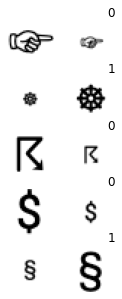

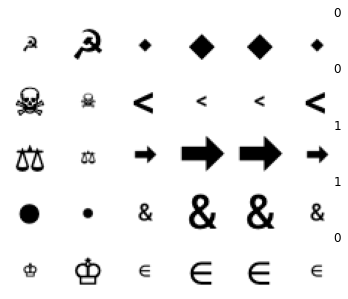

In [10]:
def display_sample(X, y, to_show=10):
    seq_len = int(X.shape[1]/2)
    fig, axarr = plt.subplots(to_show, 2*seq_len, figsize=(2*seq_len, 5))
    plt.rcParams['axes.titlepad'] = -14  
    for i in range(to_show):
        ind = np.random.choice(range(len(X)), 1)[0]
        for j in range(2*seq_len):
            axarr[i,j].imshow(X[ind,j], cmap='gray_r')
            axarr[i,j].axis('off')
            if (j == 2*seq_len-1):
                axarr[i,j].set_title('%d' % y[ind], loc='right')
    plt.show()


display_sample(X_pair, y_pair, to_show=5)
display_sample(X_train, y_train, to_show=5)


In [11]:
from simplest_abstractor import SimplestAbstractorCNN
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_abstractor = SimplestAbstractorCNN(num_classes=2, sequence_len=6, symbol_dim=10, embedding_dim=64)
cnn_abstractor.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
cnn_abstractor(X_full[:32])
cnn_abstractor.summary()


Model: "simplest_abstractor_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 cnn_embedder (TimeDistribut  multiple                 104704    
 ed)                                                             
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 key_projection (Dense)      multiple                  4160      
                                                                 
 hidden_layer (Dense)        multiple                  1952      
                                           

In [13]:
history = cnn_abstractor.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=10, verbose=1, batch_size=32)

Epoch 1/10
279/279 [==============================] - 12s 44ms/step - loss: 0.6928 - binary_accuracy: 0.5112 - val_loss: 0.6930 - val_binary_accuracy: 0.5128
Epoch 2/10
279/279 [==============================] - 11s 41ms/step - loss: 0.6935 - binary_accuracy: 0.5081 - val_loss: 0.6922 - val_binary_accuracy: 0.5230
Epoch 3/10
279/279 [==============================] - 13s 45ms/step - loss: 0.3467 - binary_accuracy: 0.8022 - val_loss: 0.0221 - val_binary_accuracy: 0.9997
Epoch 4/10
279/279 [==============================] - 12s 45ms/step - loss: 0.0115 - binary_accuracy: 0.9999 - val_loss: 0.0060 - val_binary_accuracy: 1.0000
Epoch 5/10
279/279 [==============================] - 13s 46ms/step - loss: 0.0044 - binary_accuracy: 1.0000 - val_loss: 0.0031 - val_binary_accuracy: 1.0000
Epoch 6/10
279/279 [==============================] - 13s 45ms/step - loss: 0.0025 - binary_accuracy: 1.0000 - val_loss: 0.0020 - val_binary_accuracy: 1.0000
Epoch 7/10
279/279 [==============================] 

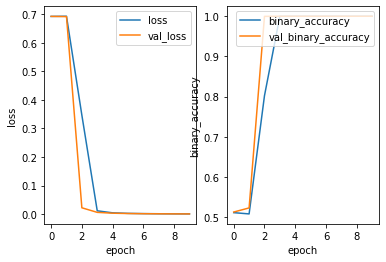

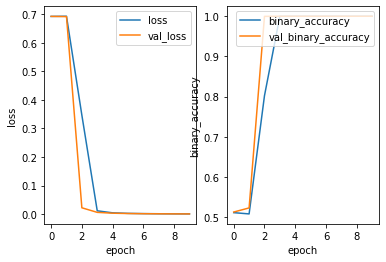

In [14]:
utils.plot_history(history, ('loss', 'binary_accuracy'))

In [15]:
out = cnn_abstractor(X_train)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('train accuracy: %.2f%%\n' % (100*np.mean(yhat==y_train)))

train accuracy: 100.00%



In [16]:
out = cnn_abstractor(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))


test accuracy: 100.00%



In [18]:
pretrained_abstractor = SimplestAbstractorCNN(num_classes=2, sequence_len=6, symbol_dim=10, embedding_dim=64)
pretrained_abstractor.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
pretrained_abstractor(X_train[:32])
pretrained_abstractor.summary()


Model: "simplest_abstractor_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 cnn_embedder (TimeDistribut  multiple                 104704    
 ed)                                                             
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 key_projection (Dense)      multiple                  4160      
                                                                 
 hidden_layer (Dense)        multiple                  1952      
                                           

In [20]:
out = pretrained_abstractor(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('pretrained test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))

pretrained test accuracy: 48.28%



In [21]:
pretrained_relation = SimplestAbstractorCNN(num_classes=2, sequence_len=2, symbol_dim=10, embedding_dim=64)
pretrained_relation.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
pretrained_relation(X_pair[:32])
pretrained_relation.summary()

Model: "simplest_abstractor_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 cnn_embedder (TimeDistribut  multiple                 104704    
 ed)                                                             
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 key_projection (Dense)      multiple                  4160      
                                                                 
 hidden_layer (Dense)        multiple                  672       
                                           

In [23]:
pretrained_relation.load_weights("larger_than_relation_weights")
out = pretrained_relation(X_pair)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('relation accuracy: %.2f%%\n' % (100*np.mean(yhat==y_pair)))

relation accuracy: 100.00%



In [24]:
pretrained_abstractor = SimplestAbstractorCNN(num_classes=2, sequence_len=6, symbol_dim=10, embedding_dim=64)
pretrained_abstractor.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
pretrained_abstractor(X_train[:32])
pretrained_abstractor.summary()

Model: "simplest_abstractor_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 cnn_embedder (TimeDistribut  multiple                 104704    
 ed)                                                             
                                                                 
 flatten_13 (Flatten)        multiple                  0         
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 key_projection (Dense)      multiple                  4160      
                                                                 
 hidden_layer (Dense)        multiple                  1952      
                                           

In [25]:
# load pretrained relational cross attention
pretrained_abstractor.cnn_encoder.set_weights(pretrained_relation.cnn_encoder.get_weights())
pretrained_abstractor.cnn_embedder.set_weights(pretrained_relation.cnn_embedder.get_weights())
pretrained_abstractor.query_projection.set_weights(pretrained_relation.query_projection.get_weights())
pretrained_abstractor.key_projection.set_weights(pretrained_relation.key_projection.get_weights())


# load pretrained symbolic processing rule
if (True):
    pretrained_abstractor.hidden_layer.set_weights(cnn_abstractor.hidden_layer.get_weights())
    pretrained_abstractor.final_layer.set_weights(cnn_abstractor.final_layer.get_weights())
    pretrained_abstractor.symbols = cnn_abstractor.symbols

In [26]:
num_tr = 150
history = pretrained_abstractor.fit(X_train[:num_tr], y_train[:num_tr], validation_data=(X_train[:num_tr], y_train[:num_tr]), epochs=30, verbose=1, batch_size=32)

Epoch 1/30
5/5 [==============================] - 3s 170ms/step - loss: 0.0059 - binary_accuracy: 1.0000 - val_loss: 0.0042 - val_binary_accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 0s 65ms/step - loss: 0.0040 - binary_accuracy: 1.0000 - val_loss: 0.0033 - val_binary_accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 62ms/step - loss: 0.0031 - binary_accuracy: 1.0000 - val_loss: 0.0028 - val_binary_accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 64ms/step - loss: 0.0027 - binary_accuracy: 1.0000 - val_loss: 0.0024 - val_binary_accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 69ms/step - loss: 0.0023 - binary_accuracy: 1.0000 - val_loss: 0.0021 - val_binary_accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 84ms/step - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 0.0019 - val_binary_accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 69ms/step - loss: 0.0018 - b

In [27]:
out = pretrained_abstractor(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('pretrained test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))

pretrained test accuracy: 99.90%



In [28]:
def initialize_pretrained_abstractor(pretrained_relation=None):

    pretrained_abstractor = SimplestAbstractorCNN(num_classes=2, sequence_len=6, symbol_dim=10, embedding_dim=64)
    pretrained_abstractor.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    pretrained_abstractor(X_full[:32])

    # load pretrained relational cross attention
    if (pretrained_relation != None):
        pretrained_abstractor.cnn_encoder.set_weights(pretrained_relation.cnn_encoder.get_weights())
        pretrained_abstractor.cnn_embedder.set_weights(pretrained_relation.cnn_embedder.get_weights())
        pretrained_abstractor.query_projection.set_weights(pretrained_relation.query_projection.get_weights())
        pretrained_abstractor.key_projection.set_weights(pretrained_relation.key_projection.get_weights())

    return pretrained_abstractor 

In [29]:
def create_callbacks(patience=7):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=0, start_from_epoch=30, mode='auto', restore_best_weights=True, verbose=True))
    return callbacks

def train_abstractor_models(train_sizes, num_trials, num_epochs, relation=None):
    from tqdm import tqdm
    from sklearn.model_selection import train_test_split
    accs = list()
    n_val = 100
    for n in tqdm(train_sizes):
        trial_accs = []
        for trial in np.arange(num_trials):
            model = initialize_pretrained_abstractor(pretrained_relation=relation)
            X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, train_size=n, test_size=n_val)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=create_callbacks(), epochs=num_epochs, verbose=0)
            out = model(X_test)
            yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
            acc = 100*np.mean(yhat==y_test)
            trial_accs.append(acc)
        accs.append(trial_accs)
    return accs

In [ ]:
num_epochs = 200
num_trials = 10

pretrained_n = [5, 10, 50, 100, 150, 200, 250, 300]
pretrained_accs = train_abstractor_models(pretrained_n, num_trials=num_trials, num_epochs=num_epochs,   relation=pretrained_relation)


In [ ]:
num_epochs = 200
num_trials = 50
de_novo_n = [50, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
de_novo_accs = train_abstractor_models(de_novo_n, num_trials=num_trials, num_epochs=num_epochs, relation=None)



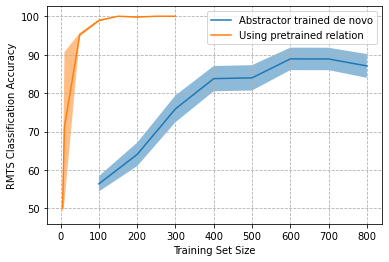

In [156]:
def plot_comparison(pretrained_n, pretrained_accs, scratch_n, scratch_accs):
    import scipy.stats
    scratch_accuracy = np.mean(scratch_accs, axis=1)
    scratch_acc_sem = scipy.stats.sem(scratch_accs, axis=1)
    pretrained_accuracy = np.mean(pretrained_accs, axis=1)
    pretrained_acc_sem = scipy.stats.sem(pretrained_accs, axis=1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(scratch_n, scratch_accuracy, label='Abstractor trained de novo')
    ax.fill_between(scratch_n, scratch_accuracy - scratch_acc_sem,
        scratch_accuracy + scratch_acc_sem, alpha=0.5)
    ax.plot(pretrained_n, pretrained_accuracy, label='Using pretrained relation')
    ax.fill_between(pretrained_n, pretrained_accuracy - pretrained_acc_sem,
        pretrained_accuracy + pretrained_acc_sem, alpha=0.5)
    ax.set_xlabel('Training Set Size')
    ax.legend()
    ax.set_ylabel('RMTS Classification Accuracy')
    ax.grid(linestyle='dashed')
    fig.savefig('rmts_accuracies.pdf')
    plt.show()

plot_comparison(pretrained_n, pretrained_accs, de_novo_n, de_novo_accs)


